In [2]:
%matplotlib widget
import numpy as np
from pygdsm import GlobalSkyModel
from pygdsm import GSMObserver
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
from astropy import units as u
from numpy.fft import fft,fftshift,ifft,ifftshift

from datetime import datetime,timedelta

from astropy.coordinates import SkyCoord, UnitSphericalRepresentation, EarthLocation, AltAz
from astropy.time import Time
from astropy import constants as const
from scipy import io

import h5py
from os import listdir
from os.path import isfile,join
from time import sleep
import csv

import numpy.ma as ma
from tqdm import tqdm  


from astropy.utils.iers import conf
conf.auto_max_age = None

In [3]:
lat = '52.9145'
long = '6.6031'
time_step = 10 #minutes
time_interval = 60*24*3 #minutes
datestr="2022-10-21-02-00-00"
date_time = datetime.strptime(datestr,"%Y-%m-%d-%H-%M-%S")
lbanr=[16,33,34,36,72,77,82,83,94]

freqMHz=62
freq=int(freqMHz)*u.MHz
num_pix = 51 # number of pixels for the model


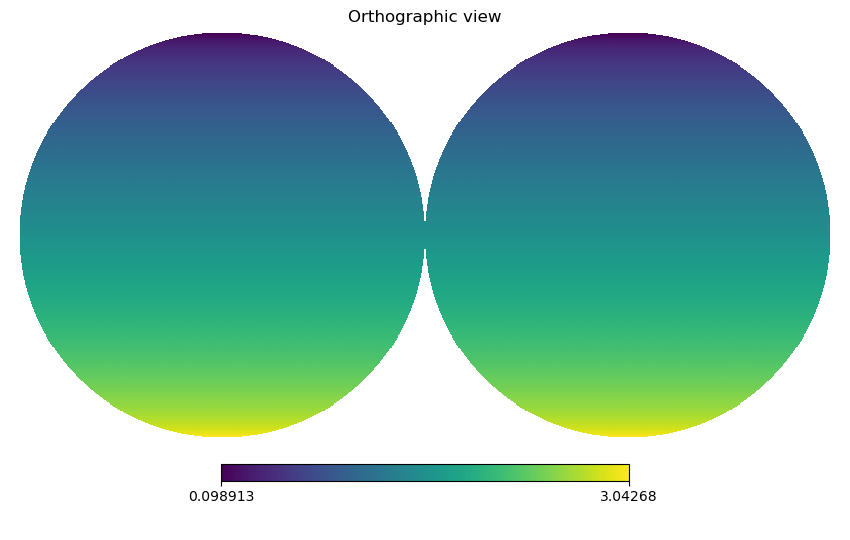

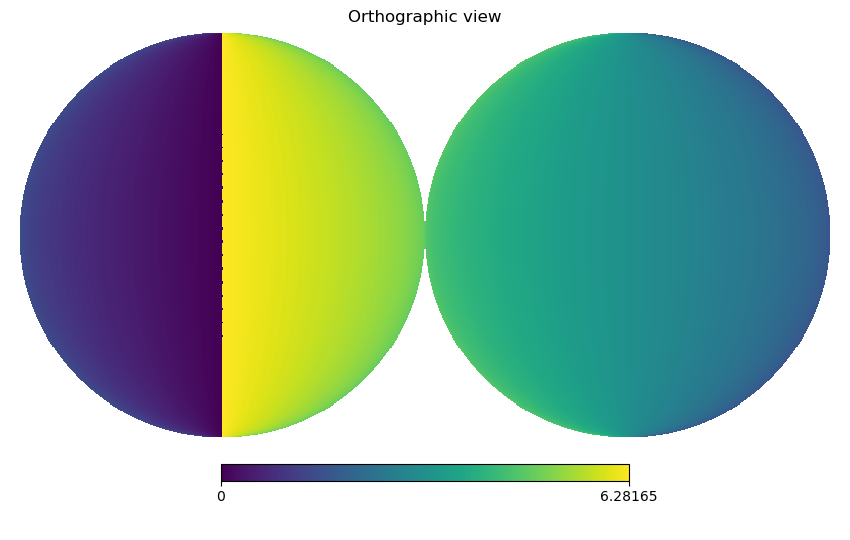

In [61]:
#def get_coord(nside=512):
if True:
    npix=hp.nside2npix(nside)
    test=np.array(hp.pix2vec(nside,range(npix))).T
    test2=test.copy();
    test2[0]=test[1]
    test2[1]=test[0]
    test2=hp.vec2ang(test)
#    print(test[1])
#    r = hp.Rotator(deg=True, rot=[0,90])

#    map_rot = np.zeros(npix)

#    test2=  r(test[1]/180*np.pi,test[0]/180*np.pi)
#        tpix = int(trot*180./np.pi) #my data came in a theta, phi grid -- this finds its location there
#        ppix = int(prot*180./np.pi)
#    map_rot[i] = map[ppix,tpix] #this being the rright way round may need double-checking
    hp.orthview(test2[0])
    hp.orthview(test2[1])
#    print(az1)
    #az1=az1/180*np.pi()
    #alt1=hp.orthview(test[1],rot=[0,90],return_projected_map=True)
    #print(alt1)
    #alt1=alt1/180*np.pi()
#    plt.close()
#    mask = np.ones(len(az1), dtype = bool)*False
#    az_rad = np.ma.masked_array(az1, mask = mask )
#    z_rad = np.ma.masked_array(np.pi/2-alt1, mask = mask)
  
#    az_rad.mask[z_rad>np.pi/2] = True
#    z_rad.mask[z_rad>np.pi/2] = True
#    return az_rad,z_rad 

#az_rad,z_rad=get_coord()

#hp.orthview(alt_az_coords.az.rad)
#hp.orthview(alt_az_coords.alt.rad)
#r = hp.Rotator(deg=True, rot=[90, 0])
#test2=r(test)
#hp.orthview(test[1])
#print()
#print(ov._n_side)

In [7]:
# The frequency does not matter since we only care about the coordinates and we use the right time for them

(latitude, longitude, elevation) = (lat, long, 0)

ov = GSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation
ov.date = date_time
ov.generate(freq.value)

observing_location = EarthLocation(lat=lat, lon=long, height=0*u.m) 
date_time_str = date_time.strftime("%Y-%m-%d %H:%M:%S")

observing_time = Time(date_time_str)  
altaz = AltAz(location=observing_location, obstime=observing_time)

coord = SkyCoord(ov._observed_ra*u.deg, ov._observed_dec*u.deg) # default is ra dec
alt_az_coords = coord.transform_to(altaz)

mask = np.ones(len(alt_az_coords), dtype = bool)*False
az_rad = np.ma.masked_array(alt_az_coords.az.rad, mask = mask )
z_rad = np.ma.masked_array(np.pi/2-alt_az_coords.alt.rad, mask = mask)

az_rad.mask[z_rad>np.pi/2] = True
z_rad.mask[z_rad>np.pi/2] = True

#hp.orthview(az_rad, half_sky = False, title = 'Azimuth')
#hp.orthview(z_rad, half_sky = False, title = 'Zenith')

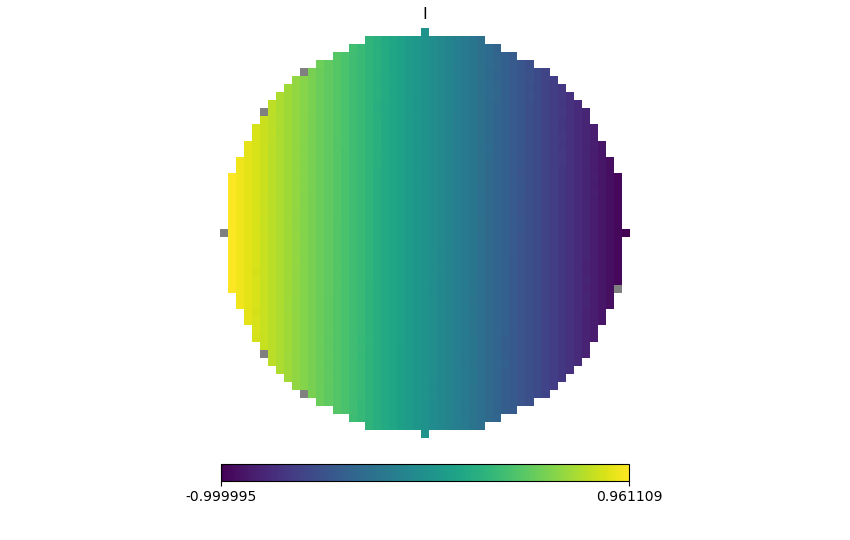

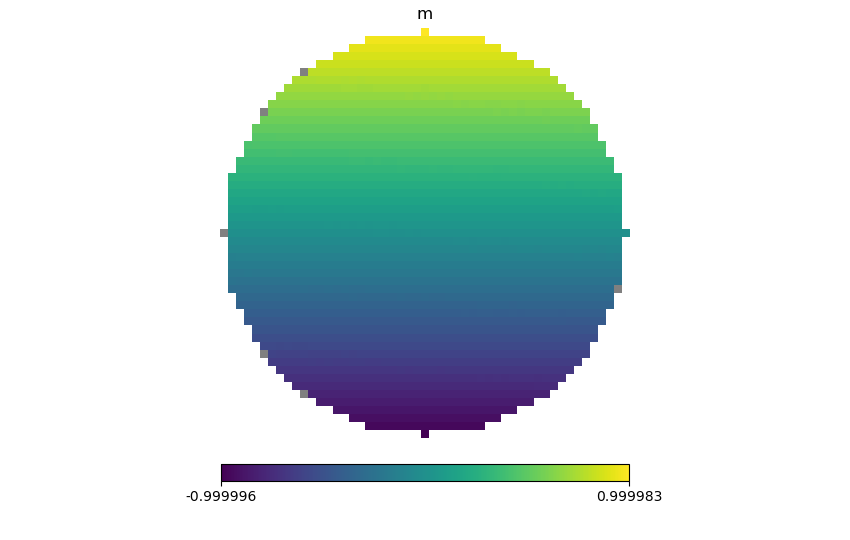

In [29]:
# Lasly, we convert the alt az coordinates to m and l
m = np.cos(az_rad)*np.sin(z_rad)
l = np.sin(az_rad)*np.sin(z_rad)

l = hp.orthview(l, half_sky = True, title = 'l', xsize = num_pix, return_projected_map = True)
m = hp.orthview(m, half_sky = True, title = 'm', xsize = num_pix, return_projected_map = True)

3145728
31212
512


In [34]:
#len(ov.observed_sky.data)
#ov._observed_ra
#ov._observed_ra
print(alt_az_coords)
import healpy as hp
hp.pix2ang(num_pix, 0)

<SkyCoord (AltAz: obstime=2022-10-21 02:00:00.000, location=(3828707.24242384, 443206.46999289, 5064811.62159911) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(3.21660350e-01,  0.07611343), (3.28885691e-01, -0.05624157),
     (1.33619660e-01, -0.1096007 ), ..., (1.80117460e+02, -0.01572302),
     (1.80312810e+02, -0.06918029), (1.80320035e+02,  0.06316894)]>


(0.016009907864302675, 0.7853981633974483)

In [13]:
class LBArad:
    __init__ (self,path,alt_az_coords):
        self.path=path
        self.alt_az_coords=alt_az_coords
    def filename(self,freq):
        return path+'lba_CS001_single_ended_pat_freq%imhz.mat'%freqMHz
    def getbeam(self,freq,lbas):

        

B1=LBArad('data/',alt_az_coords)
        
def read_beam_and_convert_to_healpy(filename,lbanr):
    r'''
    Reads a MatLab file with the beam simulation and converts it into a healpy projection.
    
    Input: str
        The path and name of the MatLab file
    Returns: ndarray
        The beam pattern in healpy projection for each frequency and polarization.
    '''
    from tqdm import tqdm
    
    file = io.loadmat(filename)
    frequency_beam = np.array(file["Freq"][0])
    phi_beam = np.array(file["Phi"][0])
    theta_beam = np.array(file["Theta"][0])
    Vdiff_pol1_beam = np.array(file["Vdiff_pol1"][lbanr])
    Vdiff_pol2_beam = np.array(file["Vdiff_pol2"][lbanr])
    Nlba=len(lbanr)
    print("freq=",frequency_beam,"N phi=",len(phi_beam)," N theta",len(theta_beam),Vdiff_pol1_beam.shape)
    beam_pattern = np.ones((Nlba,2,91,73))
    beam_pattern[:,0] = (Vdiff_pol1_beam[:,0]*np.conjugate(Vdiff_pol1_beam[:,0])+Vdiff_pol1_beam[:,1]*np.conjugate(Vdiff_pol1_beam[:,1])).real
    beam_pattern[:,1] = (Vdiff_pol2_beam[:,0]*np.conjugate(Vdiff_pol2_beam[:,0])+Vdiff_pol2_beam[:,1]*np.conjugate(Vdiff_pol2_beam[:,1])).real
    #beam_pattern[2] = (Vdiff_pol1_beam[0]*np.conjugate(Vdiff_pol2_beam[0])+Vdiff_pol1_beam[1]*np.conjugate(Vdiff_pol2_beam[1]))
    #beam_pattern[3] = (Vdiff_pol2_beam[0]*np.conjugate(Vdiff_pol1_beam[0])+Vdiff_pol2_beam[1]*np.conjugate(Vdiff_pol1_beam[1]))

    beam_pattern_power = (beam_pattern)/75 # 75 Omh is the resistance 

    alt_az_coords = coord.transform_to(altaz)

    az_deg = alt_az_coords.az.degree
    z_deg = 90-alt_az_coords.alt.degree

    beam_sky = np.zeros((2, ov._n_pix))
    beam_final = np.zeros((Nlba,2, num_pix, num_pix))
    for ilba in tqdm(range(Nlba)):
      for ind in range(len(alt_az_coords)):
            if z_deg[ind] < 91:
                    beam_sky[:,ind] = beam_pattern_power[ilba,:,int(z_deg[ind]), int(az_deg[ind]/5)]
                
      beam_final[ilba,0] = hp.orthview(beam_sky[0,:], half_sky = True, xsize = num_pix, return_projected_map = True, fig = 7)
      beam_final[ilba,1] = hp.orthview(beam_sky[1,:], half_sky = True, xsize = num_pix, return_projected_map = True, fig = 7)
      plt.close()
    beam_sky = None
    return beam_final


In [14]:
beam_sky = read_beam_and_convert_to_healpy('antenna/lba_CS001_single_ended_pat_freq%imhz.mat'%freqMHz,lbanr=lbanr)

freq= [62000000] N phi= 73  N theta 91 (9, 2, 91, 73)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.24s/it]


In [15]:

#plt.figure()
#plt.subplot(1, 2, 1)
#plt.imshow(beam_sky[0].real, origin = 'lower')


#plt.subplot(1, 2, 2)
#plt.imshow(beam_sky[1].real, origin = 'lower')
#plt.show()

In [16]:
if True:
    Nlba=len(lbanr)
    (latitude, longitude, elevation) = (lat, long, 0)
    date0=date_time;
    Ntime=time_interval//time_step
    tdelta = timedelta(minutes = time_step)
    pwr=np.zeros([Nlba,2,Ntime])
    for x in  tqdm(range(Ntime)):

        ov = GSMObserver()
        ov.lon = longitude
        ov.lat = latitude
        ov.elev = elevation
        ov.date = date0
        ov.generate(freq.value)
       
    
        sky_temp = hp.orthview(ov.observed_sky, half_sky = True, title = 'T_sky', xsize = num_pix, return_projected_map = True)
        plt.close()
        sky_intensity = (2*const.k_B.value*sky_temp/(const.c.value**2)*(freq.value*10**6)**2)
        for i in range(Nlba):
            pwr[i,0,x]=np.sum( sky_intensity*beam_sky[i,0])
            pwr[i,1,x]=np.sum( sky_intensity*beam_sky[i,1])
        date0+=tdelta

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [09:11<00:00,  1.28s/it]


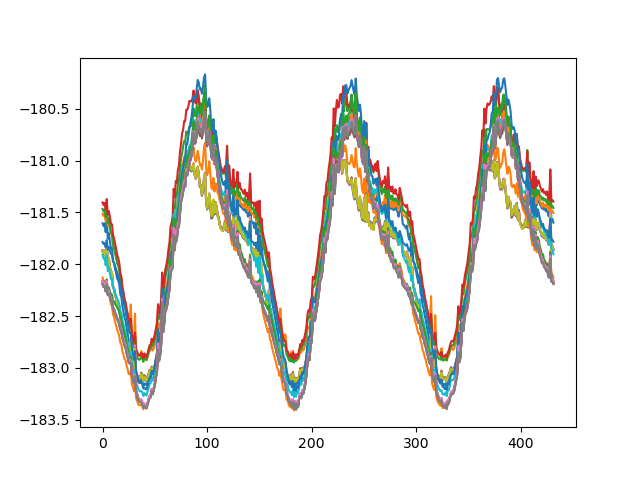

In [17]:
plt.figure()
plt.plot(10*np.log10(pwr[:,0].T));
plt.plot(10*np.log10(pwr[:,1].T));
np.save("Sky%i"%freqMHz,pwr)
plt.show()